# Import

In [46]:
import ray
import pandas as pd
import os
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import json
import nltk
import re
import numpy as np
import sys

from dataclasses import dataclass
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer
from ray.data import Dataset
from typing import Dict, List, Tuple

# Config

In [2]:
@dataclass
class Config:
    # ray resources
    cpu_per_worker: int = 1
    gpu_per_worker: int = 0
    num_workers:int = 2

    # data
    data_path:str = os.path.join("..", "datasets", "dataset.csv")
    train_ratio:float = 0.6
    test_ratio:float = 0.2
    val_ratio:float = 0.2

    # reproducibility
    seed:int = 2207888

CFG = Config()
print(CFG)

Config(cpu_per_worker=1, gpu_per_worker=0, num_workers=2, data_path='../datasets/dataset.csv', train_ratio=0.6, test_ratio=0.2, val_ratio=0.2, seed=2207888)


# Reproducibility 

In [3]:
def make_reproducible(seed=220788):
    """Set seeds for reproducibility."""
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)  # should be equivalent to the 2 lines below
    # eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    # eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    
    # when using ray, we need to add this to our make_reproducible function
    # ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [4]:
make_reproducible(CFG.seed)

# Ray Server

In [5]:
# restart ray server (127.0.0.1:8265)
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-12-18 07:11:21,687	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.0
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [6]:
# list detected resources
ray.cluster_resources()

{'node:__internal_head__': 1.0,
 'node:127.0.0.1': 1.0,
 'object_store_memory': 1629963878.0,
 'CPU': 8.0,
 'memory': 3259927758.0}

In [7]:
# config actual num workers and their resoruces
num_workers = CFG.num_workers
resources_per_worker = {"CPU": CFG.cpu_per_worker, "GPU": CFG.gpu_per_worker}

# Data

In [8]:
df = pd.read_csv(CFG.data_path)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [9]:
# we're interested in how many time each class occurs (this is multiclass, but not multilabel)
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

<Axes: xlabel='tag'>

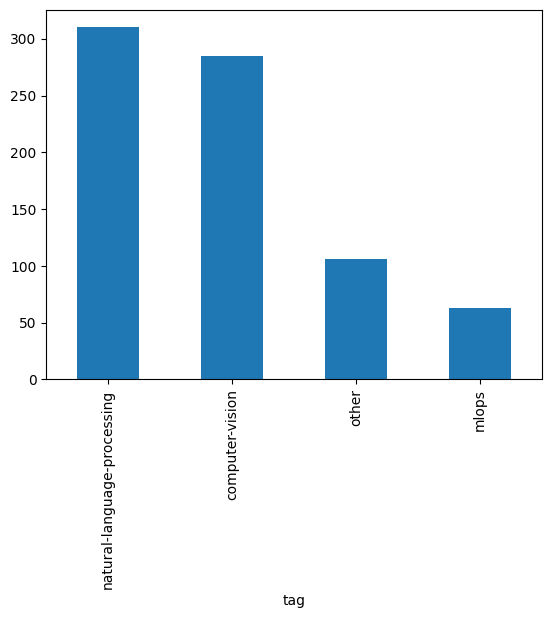

In [10]:
# graph the distribution of classes
df.tag.value_counts().plot.bar()

In [11]:
# split the dataset
train_df, test_and_val_df = train_test_split(df, test_size=1 - CFG.train_ratio, random_state=CFG.seed)
test_df, val_df = train_test_split(test_and_val_df, test_size=CFG.val_ratio / (CFG.test_ratio + CFG.val_ratio), random_state=CFG.seed)

# confirm
print(train_df.shape , test_df.shape, val_df.shape)
print("{:.2f}, {:.2f}, {:.2f}".format(train_df.shape[0] / df.shape[0], test_df.shape[0] / df.shape[0], val_df.shape[0] / df.shape[0]))

(458, 5) (153, 5) (153, 5)
0.60, 0.20, 0.20


In [12]:
# show value counts for new dfs
print(train_df.tag.value_counts())
print(test_df.tag.value_counts())
print(val_df.tag.value_counts())

tag
computer-vision                182
natural-language-processing    178
other                           59
mlops                           39
Name: count, dtype: int64
tag
natural-language-processing    64
computer-vision                48
other                          26
mlops                          15
Name: count, dtype: int64
tag
natural-language-processing    68
computer-vision                55
other                          21
mlops                           9
Name: count, dtype: int64


Proportions are roughly maintained thanks to randomness, I believe.

To preserve class balance via a generator, use `sklearn.model_selection.StratifiedShuffleSplit¶`

# Exploratory Data Analysis
Show the data that we'll be working on.

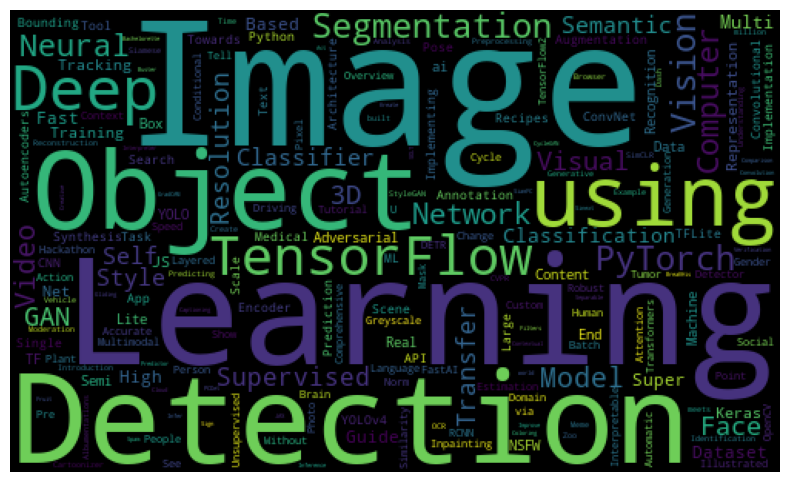

In [17]:

# Most frequent tokens for each tag
tag="computer-vision"
plt.figure(figsize=(12, 6))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

# Data Preprocessing

In [19]:
# Feature engineering
df["text"] = df.title + " " + df.description

In [25]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /Users/maju/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [28]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [29]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [30]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'other': 0,
 'computer-vision': 1,
 'natural-language-processing': 2,
 'mlops': 3}

In [31]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,1
1,show infer tell contextual inference creative ...,1
2,awesome graph classification collection import...,0
3,awesome monte carlo tree search curated list m...,0
4,attentionwalk pytorch implementation watch ste...,0


In [32]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [33]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

In [35]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [36]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [37]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([1])}

In [38]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [39]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,  3450,  1183, ...,     0,     0,     0],
        [  102,   572, 27925, ...,     0,     0,     0],
        [  102, 10022, 28377, ...,     0,     0,     0],
        ...,
        [  102, 13641,  1804, ...,     0,     0,     0],
        [  102,  3158, 26074, ...,     0,     0,     0],
        [  102, 18403, 30114, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 2, 3, 2, 1, 0, 1, 0, 1, 1, 0, 2, 3, 2, 0, 2, 2, 1, 2, 1,
        1, 1, 0, 2, 1, 2, 1, 2, 3, 2, 0, 3, 0, 2, 0, 1, 1, 2, 1, 1, 1, 1,
        3, 1, 2, 1, 2, 1, 2, 1, 3, 1, 1, 2, 2, 0, 0, 1, 2, 1, 1, 1, 2, 2,
        1, 0, 1, 1, 2, 2, 3, 3, 3, 2, 2, 1, 1, 2, 2, 2, 2, 3, 1, 1, 2, 1,
        1, 2, 1, 2, 3, 2, 2, 3, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 3, 2,
        2, 1, 2, 2, 1, 2, 1, 2, 0

# Ray (for data preprocessing)

In [40]:
# we'll move our data preprocessing to distributed via ray
ray_context = ray.data.DatasetContext.get_current()
ray_context

In [41]:
# when using ray, we need to add this to our make_reproducible function
ray_context.execution_options.preserve_order = True

In [42]:
# data intake
ds = ray.data.read_csv(CFG.data_path)
ds = ds.random_shuffle(seed=CFG.seed)
ds.take(1)

2023-12-18 07:28:28,504	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2023-12-18 07:28:28,662	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-12-18 07:28:28,680	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-12-18 07:28:28,689	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-18 07:28:28,690	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 2166,
  'created_on': datetime.datetime(2020, 8, 17, 5, 19, 41),
  'title': 'Pix2Pix',
  'description': 'Tensorflow 2.0 Implementation of the paper Image-to-Image Translation using Conditional GANs by Philip Isola, Jun-Yan Zhu, Tinghui Zhou and Alexei A. Efros.',
  'tag': 'computer-vision'}]

## Ray Splitting
Will need some custom code to maintain stratification (proportions?) based on the label column (called `tag`).

In [47]:
def mwml_stratify_split(
    ds: Dataset,
    stratify: str,
    test_size: float,
    shuffle: bool = True,
    seed: int = 1234,
) -> Tuple[Dataset, Dataset]:
    """Split a dataset into train and test splits with equal
    amounts of data points from each class in the column we
    want to stratify on.

    Args:
        ds (Dataset): Input dataset to split.
        stratify (str): Name of column to split on.
        test_size (float): Proportion of dataset to split for test set.
        shuffle (bool, optional): whether to shuffle the dataset. Defaults to True.
        seed (int, optional): seed for shuffling. Defaults to 1234.

    Returns:
        Tuple[Dataset, Dataset]: the stratified train and test datasets.
    """

    def _add_split(df: pd.DataFrame) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Naively split a dataframe into train and test splits.
        Add a column specifying whether it's the train or test split."""
        train, test = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=seed)
        train["_split"] = "train"
        test["_split"] = "test"
        return pd.concat([train, test])

    def _filter_split(df: pd.DataFrame, split: str) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Filter by data points that match the split column's value
        and return the dataframe with the _split column dropped."""
        return df[df["_split"] == split].drop("_split", axis=1)

    # Train, test split with stratify
    grouped = ds.groupby(stratify).map_groups(_add_split, batch_format="pandas")  # group by each unique value in the column we want to stratify on
    train_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "train"}, batch_format="pandas")  # combine
    test_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "test"}, batch_format="pandas")  # combine

    # Shuffle each split (required)
    train_ds = train_ds.random_shuffle(seed=seed)
    test_ds = test_ds.random_shuffle(seed=seed)

    return train_ds, test_ds

In [48]:
# Split dataset
test_size = 0.2
train_ds, val_ds = mwml_stratify_split(ds, stratify="tag", test_size=test_size)

2023-12-18 07:33:07,039	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-12-18 07:33:07,045	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-18 07:33:07,046	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

And now we can use the previously made preprocessing function in conjuntion **ray's** `map_batches()` function.

In [49]:
tags = train_ds.unique(column="tag")
tags

2023-12-18 07:35:51,914	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-12-18 07:35:51,916	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-18 07:35:51,918	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-12-18 07:35:53,688	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-12-18 07:35:53,739	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-18 07:35:53,744	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

['computer-vision', 'mlops', 'natural-language-processing', 'other']

In [50]:
class_to_index = {tag: i for i, tag in enumerate(tags)}

In [51]:
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2023-12-18 07:37:47,911	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2023-12-18 07:37:47,913	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-18 07:37:47,913	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

{'ids': array([  102,  2567,  5472,  4710,  2469,  2737,  2567,  5472,  8562,
       22839,  1846,  6591,  2177,  1045,   382, 26280,  2115,   103,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


# Training


In [52]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

In [53]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(CFG.data_path)
    ds = ds.random_shuffle(seed=CFG.seed)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [54]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        
    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self
    
    def transform(self, ds):
        return ds.map_batches(
            preprocess, 
            fn_kwargs={"class_to_index": self.class_to_index}, 
            batch_format="pandas")

## Model

In [55]:
import torch.nn as nn
from transformers import BertModel

In [56]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
